# **EXPERIMENT**
## Integrating Evolutionary Algorithms and Transformers through a co-evolutionary process within a shared latent space to generate anonymised synthetic multimodal datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
path = r"C:\Users\thoma\Desktop\La_Veranda_Reviews-2023-01-16.csv"
data = pd.read_csv(path)

In [3]:
data.head()

,Title,PositiveReview,NegativeReview,Score,GuestName,GuestCountry,RoomType,NumberOfNights,VisitDate,GroupType,PropertyResponse
0,Wonderful place to stay.,"New, comfortable apartments, close to the airp...",Nothing at all.,10.0,Olga,Norway,Budget Twin Room,1 night,June 2022,Solo traveler,NaN
1,It was superb,We had a really pleasant stay! The staff was v...,NaN,10.0,Iwona,Poland,Double Room,3 nights,December 2022,Family,NaN
2,Very Good,the location is great and near the airport. bu...,NaN,8.0,Ruijia,Sweden,Double Room,1 night,December 2022,Solo traveler,NaN
3,Wonderful,Great stuff\nGreat Quality/price\nClean,NaN,9.0,Theprincem,United Kingdom,Double Room with Balcony,2 nights,September 2022,Solo traveler,NaN
4,"Fantastic value for a new, modern and spotless...","Clean and modern with very comfortable beds, i...",NaN,10.0,M,Switzerland,Family Suite with Balcony,1 night,October 2022,Family,NaN


In [4]:
df = data[['Score', 'PositiveReview']]

In [5]:
df.head()

,Score,PositiveReview
0,10.0,"New, comfortable apartments, close to the airp..."
1,10.0,We had a really pleasant stay! The staff was v...
2,8.0,the location is great and near the airport. bu...
3,9.0,Great stuff\nGreat Quality/price\nClean
4,10.0,"Clean and modern with very comfortable beds, i..."


# **Creating a shared latent space**

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA

In [7]:
df = df.dropna()

In [8]:
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(df['PositiveReview'])

In [9]:
score_features = df['Score'].values.reshape(-1, 1)
text_features_dense = text_features.toarray()
combined_features = np.concatenate((score_features, text_features_dense), axis=1)

In [10]:
n_components = 100  # leaving at 100 for now
pca = PCA(n_components=n_components)
latent_space = pca.fit_transform(combined_features)

In [11]:
#putting the initial latent space into a new dataframe
latent_df = pd.DataFrame(latent_space, columns=[f'Dimension_{i+1}' for i in range(n_components)])


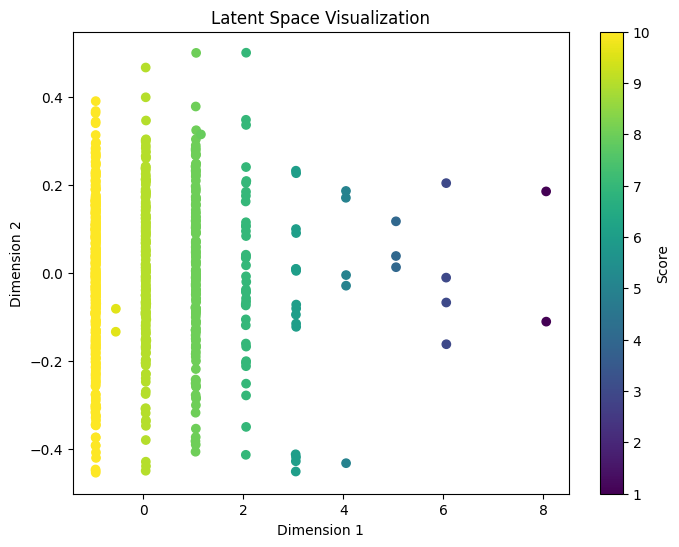

In [12]:

plt.figure(figsize=(8, 6))
plt.scatter(latent_df['Dimension_1'], latent_df['Dimension_2'], c=df['Score'], cmap='viridis')
plt.colorbar(label='Score')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('Latent Space Visualization')
plt.show()

In [13]:
reconstructed_features = pca.inverse_transform(latent_space)
reconstruction_error = np.mean(np.square(combined_features - reconstructed_features))
print(f'Reconstruction error: {reconstruction_error}')

Reconstruction Error: 0.0002227008964490821


# **Builidng an EA**

In [14]:

def create_individual(latent_space):
    return latent_space[np.random.choice(latent_space.shape[0])]

def fitness_function(individual):
    return np.sum(np.abs(individual))

population_size = 100
num_generations = 50
mutation_rate = 0.1

# creation of intitial population
population = [create_individual(latent_space) for _ in range(population_size)]

# create array to store the evolved latent space representations
evolved_latent_space = np.zeros((num_generations * population_size, latent_space.shape[1]))

for generation in range(num_generations):
    # evaluating the fitness of each individual
    fitness_scores = [fitness_function(individual) for individual in population]
    
    # selection of parents for reproduction
    parent_indices = np.random.choice(len(population), size=population_size, replace=True, p=fitness_scores/np.sum(fitness_scores))
    parents = [population[i] for i in parent_indices]
    
    # crossover generating offspring by combining parents
    offspring = []
    for i in range(0, population_size, 2):
        parent1, parent2 = parents[i], parents[i+1]
        crossover_point = np.random.randint(1, len(parent1))
        offspring1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
        offspring.extend([offspring1, offspring2])
    
    # mutation by introducing random changes to the offspring
    for i in range(population_size):
        if np.random.rand() < mutation_rate:
            mutation_index = np.random.randint(len(offspring[i]))
            offspring[i][mutation_index] += np.random.normal(scale=0.1)
    
    # storing the evolved latent space representations
    start_index = generation * population_size
    end_index = (generation + 1) * population_size
    evolved_latent_space[start_index:end_index] = offspring
    
    # replace the current population with the offspring
    population = offspring

# selecting the best individual from the final population
best_individual = max(population, key=fitness_function)
best_fitness = fitness_function(best_individual)
print(f'Best Individual: {best_individual}')
print(f'Best Fitness: {best_fitness}')

Best Individual: [ 5.05310160e+00  1.77830091e-01  5.25647589e-02 -2.21035309e-01
  1.83815394e-01 -6.84179198e-03  3.06846731e-01  9.62105470e-02
  2.83958502e-01 -7.39261687e-02 -1.26859718e-01  5.10168567e-02
 -7.08603954e-02 -2.35109228e-02  3.31821314e-02 -4.37188257e-02
 -2.61890626e-02 -1.43875057e-01 -9.02310703e-02 -8.28331505e-03
 -4.56296458e-02  1.02920184e-01  7.02308226e-02 -1.00632881e-01
 -4.02441194e-02 -9.40029283e-02 -5.78603458e-02 -1.44538231e-02
 -3.73415440e-02  9.77868459e-03  6.14010697e-02 -1.31445967e-01
 -7.86363029e-02  1.42946981e-01  3.69721861e-01  2.23493298e-02
 -5.78333065e-02 -2.74715110e-01 -1.75935567e-01 -2.51818126e-01
 -4.96377072e-02 -4.27599941e-02  5.33367609e-02  9.50703088e-02
 -8.89910401e-02  9.16406561e-02 -2.65775481e-02  1.20956474e-01
  1.24716857e-01  9.40585251e-02 -1.02552144e-01 -2.75092469e-03
  3.23463324e-02  1.19452204e-01  2.09602804e-01 -1.13458206e-01
  8.12078125e-02  1.73452922e-02  2.80682770e-02  1.46612894e-01
  5.9863

# **Building a Decoder - EXPERIMENTAL**

the synthesis in a latent space sort of works, now the decoder needs to be properly optimised so that it returns a dataset of the same shape

In [15]:
import tensorflow as tf


In [16]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(combined_features)

In [17]:

input_dim = evolved_latent_space.shape[1]
output_dim = normalized_features.shape[1]

decoder_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(input_dim,)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(output_dim, activation='sigmoid')
])

decoder_model.compile(optimizer='adam', loss='mse')

In [21]:
# Randomly sample from evolved_latent_space to match the shape of normalized_features
sample_indices = np.random.choice(evolved_latent_space.shape[0], size=normalized_features.shape[0], replace=False)
sampled_latent_space = evolved_latent_space[sample_indices]

In [22]:
batch_size = 32
epochs = 100

decoder_model.fit(sampled_latent_space, normalized_features, batch_size=batch_size, epochs=epochs)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1885  
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0032
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0031
Epoch 12/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029
Epoch 13/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 14/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Epoch 15/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0030
Ep

In [28]:
# selecting a subset of evolved_latent_space that matches the number of samples in combined_features
subset_latent_space = evolved_latent_space[:combined_features.shape[0]]

# using that subset as input to the decoder network
reconstructed_features = decoder_model.predict(subset_latent_space)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


lots of problems with matching and shapes

In [29]:
# randomly sample from combined_features to match the number of samples in reconstructed_features
sample_indices = np.random.choice(combined_features.shape[0], size=reconstructed_features.shape[0], replace=False)
sampled_combined_features = combined_features[sample_indices]

# evaluate the reconstruction quality using the sampled subset
mse = np.mean(np.square(sampled_combined_features - reconstructed_features))
print(f'Reconstruction MSE: {mse}')

Reconstruction MSE: 0.0410784752637218


In [30]:

new_latent_space = np.random.normal(loc=np.mean(evolved_latent_space, axis=0), 
                                     scale=np.std(evolved_latent_space, axis=0), 
                                     size=(100, input_dim))

synthetic_features = decoder_model.predict(new_latent_space)
synthetic_features = scaler.inverse_transform(synthetic_features)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [34]:

synthetic_df = pd.DataFrame(synthetic_features)

In [39]:
original_stats = df.describe()

print(original_stats)

            Score
count  775.000000
mean     9.053032
std      1.271203
min      1.000000
25%      8.000000
50%      9.000000
75%     10.000000
max     10.000000


In [40]:
original_stats = df.describe()
synthetic_stats = synthetic_df.describe()

print("Original Data Statistics:")
print(original_stats)
print("\nSynthetic Data Statistics:")
print(synthetic_stats)

Original Data Statistics:
            Score
count  775.000000
mean     9.053032
std      1.271203
min      1.000000
25%      8.000000
50%      9.000000
75%     10.000000
max     10.000000

Synthetic Data Statistics:
             0             1             2             3             4     \
count  100.000000  1.000000e+02  1.000000e+02  1.000000e+02  1.000000e+02   
mean     9.159148  3.121322e-05  5.355455e-04  2.532680e-04  4.783251e-05   
std      0.196796  8.505970e-05  1.179204e-03  7.563595e-04  1.387439e-04   
min      8.598324  2.016427e-09  2.082618e-07  2.837979e-08  2.424840e-09   
25%      9.032446  8.543198e-07  3.401012e-05  7.036721e-06  1.132725e-06   
50%      9.161536  4.095004e-06  1.287063e-04  3.201698e-05  5.509666e-06   
75%      9.289107  1.749859e-05  4.116801e-04  1.148714e-04  2.355202e-05   
max      9.658441  6.208185e-04  7.586729e-03  6.122454e-03  1.027782e-03   

               5             6             7             8             9     \
count  1.00